# Importo le librerie e i pacchetti necessari

In [1]:
!pip install catboost

     |████████████████████████████████| 65.8MB 44kB/s 


In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import matplotlib.pyplot as plt
import seaborn as sns 

from shapely.geometry import Point
import folium

import datetime
from datetime import timedelta

import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb

from sklearn import metrics

from catboost import CatBoostRegressor

from keras.layers import Dense, Dropout, BatchNormalization, Input, GaussianNoise
from keras.models import Sequential
from keras.initializers import GlorotUniform
from keras import regularizers

import tensorflow as tf

#Funzioni utili

In [4]:
def plot_history(network_history):
    """The return value of the fit function is a keras.callbacks.History object which 
  contains the entire history of training/validation loss and accuracy, for each epoch."""

    plt.figure(figsize=(16,5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(x_plot, network_history.history['mse'])
    plt.plot(x_plot, network_history.history['val_mse'])
    plt.legend(['Training', 'Validation'])
    plt.show()

In [5]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [6]:
def performance(pred, true):
    mae = metrics.mean_absolute_error(pred, true)
    mse = metrics.mean_squared_error(pred, true)
    rmse = np.sqrt(metrics.mean_squared_error(pred, true))
    r2 = metrics.r2_score(pred, true)
    return mae, mse, rmse, r2

# Importo i dati

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/advanced machine learning/TAXI')

Mounted at /content/drive


In [8]:
train=pd.read_csv('train_final.csv', index_col='Unnamed: 0')
y=pd.read_csv('y_final.csv', index_col='Unnamed: 0')
test=pd.read_csv('test_final.csv', index_col='Unnamed: 0')

#Train/validation split

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(train, np.log1p(y), test_size=0.3, random_state=1)

Abbiamo deciso di applicare una trasformazione logaritmica alla variabile target così che abbia una 'distribuzione normale'.

Anche se le variabili non hanno una distribuzione normale, standardizzo i dati in modo che abbiano una media pari a zero e una deviazione standard di uno. (La media e la deviazione standard sono calcolate sul train. I dati di validation e di test sono stati standardizzati utilizzando le statistiche calcolate sul train.)

In [10]:
X_trainst, scaler1 = preprocess_data(X_train)
X_validationst, _ = preprocess_data(X_validation, scaler1)

# MODELLI

## Linear Regression Regressor Model

In [11]:
lr = LinearRegression()
lr.fit(X_trainst, y_train)
lr_pred = lr.predict(X_validationst)

 ## Decision Tree Regressor Model

In [14]:
dt=DecisionTreeRegressor()
dt.fit(X_trainst, y_train)
dt_pred=dt.predict(X_validationst)

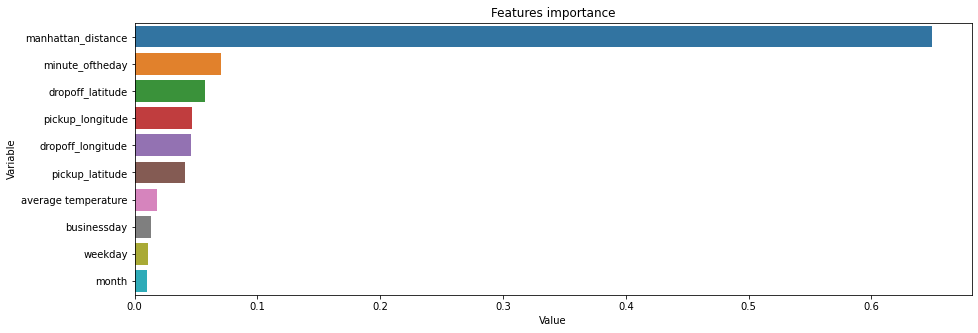

In [15]:
#feature importances
df = pd.DataFrame({'Variable': X_train.columns, 'Value':dt.feature_importances_})  #np.log(1000*
df=df[df.Value>0.01]

plt.figure(figsize=(15,5))
sns.barplot(x="Value", y="Variable", data=df.sort_values(by="Value",ascending=False))
plt.title('Features importance')
plt.show()

## AdaBoost Regressor Model

In [16]:
def mse(pred, true):
    return metrics.mean_squared_error(pred, true)

In [17]:
df = pd.DataFrame({'loss': ['square', 'exponential', 'linear'], 'mse':[0, 0, 0]})
df.set_index('loss', inplace=True)

In [18]:
#let's try three different types of loss
for loss in ['linear', 'square', 'exponential']:
  ab=AdaBoostRegressor(loss=loss) #The base estimator from which the boosted ensemble is built is DecisionTreeRegressor initialized with max_depth=3.
  ab.fit(X_trainst, y_train)
  ab_pred=ab.predict(X_validationst)
  df.loc[loss, 'mse']=mse(ab_pred, y_validation.values)

In [19]:
df

,mse
loss,
square,0.274131
exponential,0.204691
linear,0.204126


Le performance migliori si ottengono con una loss lineare.

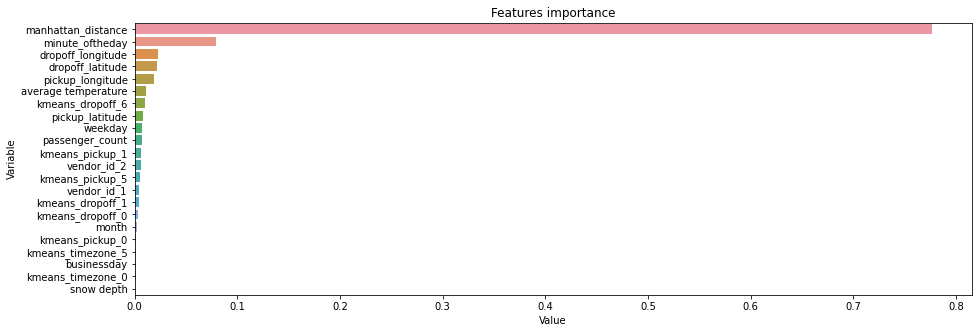

In [20]:
#feature importances
df = pd.DataFrame({'Variable': X_train.columns, 'Value':ab.feature_importances_})  #np.log(1000*
df=df[df.Value>0]

plt.figure(figsize=(15,5))
sns.barplot(x="Value", y="Variable", data=df.sort_values(by="Value",ascending=False))
plt.title('Features importance')
plt.show()

## XGB Regressor Model

In [21]:
xgb= XGBRegressor();
xgb.fit(X_trainst, y_train)
xgb_pred=xgb.predict(X_validationst)

[11:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


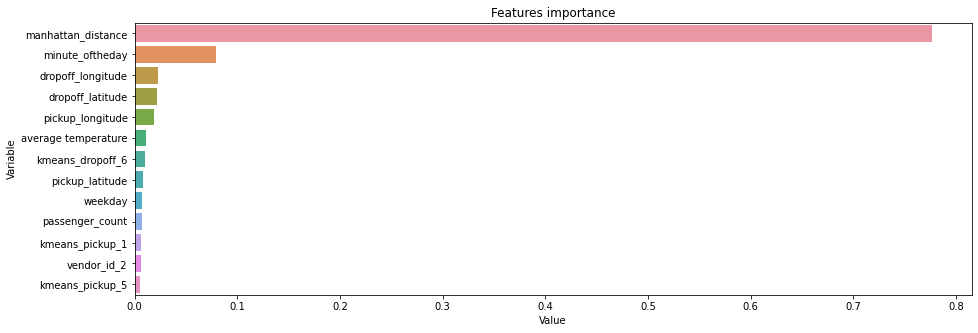

In [22]:
#feature importances
df = pd.DataFrame({'Variable': X_train.columns, 'Value':ab.feature_importances_})  #np.log(1000*
df=df[df.Value>0.005]

plt.figure(figsize=(15,5))
sns.barplot(x="Value", y="Variable", data=df.sort_values(by="Value",ascending=False))
plt.title('Features importance')
plt.show()

## LGBM Regressor Model

In [23]:
lgbm = lgb.LGBMRegressor(importance_type='gain')
lgbm.fit(X_trainst, y_train)
lgbm_pred = lgbm.predict(X_validationst)

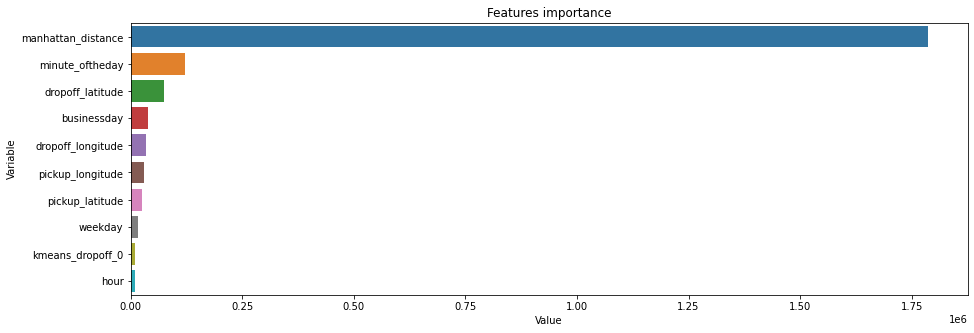

In [24]:
#feature importances
df = pd.DataFrame({'Variable': X_train.columns, 'Value':lgbm.feature_importances_})  #np.log(1000*
df=df[df.Value>8000]

plt.figure(figsize=(15,5))
sns.barplot(x="Value", y="Variable", data=df.sort_values(by="Value",ascending=False))
plt.title('Features importance')
plt.show()

## CatBoostRegressor Model

In [25]:
cb=CatBoostRegressor()
cb.fit(X_trainst, y_train, logging_level='Silent')
cb_pred=dt.predict(X_validationst)

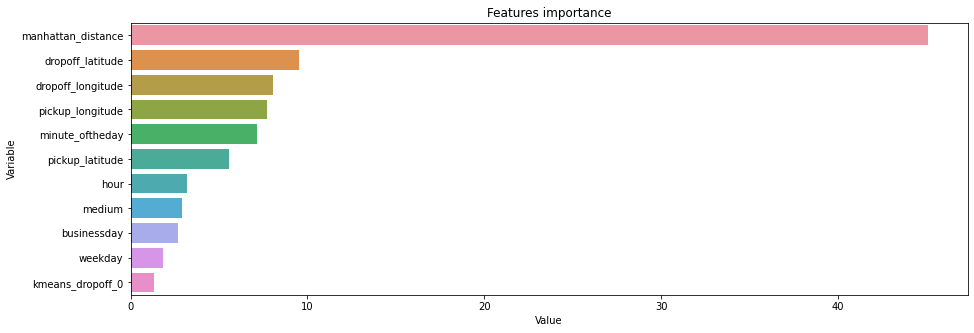

In [26]:
#feature importances
df = pd.DataFrame({'Variable': X_train.columns, 'Value':cb.feature_importances_})  #np.log(1000*
df=df[df.Value>1]

plt.figure(figsize=(15,5))
sns.barplot(x="Value", y="Variable", data=df.sort_values(by="Value",ascending=False))
plt.title('Features importance')
plt.show()

## Neural Network

Dato l'elevato numero di dati, abbiamo deciso di provare una deep neural network per prevedere la durata del viaggio in taxi.  
Partiamo da un modello molto semplice, con tre layer.

In [27]:
epochs=20

In [28]:
#model 1
model1 = Sequential() 
model1.add(Dense(1024, activation = 'relu', input_shape=( X_train.shape[1],)))
model1.add(Dense(512, activation = 'relu'))
model1.add(Dense(1))

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              47104     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 572,417
Trainable params: 572,417
Non-trainable params: 0
_________________________________________________________________


In [30]:
model1.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history1=model1.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.4726 - mse: 0.4726 - mae: 0.3954 - val_loss: 0.1614 - val_mse: 0.1614 - val_mae: 0.3014
Epoch 2/20
3951/3951 [==============================] - 12s 3ms/step - loss: 0.1399 - mse: 0.1399 - mae: 0.2793 - val_loss: 0.1385 - val_mse: 0.1385 - val_mae: 0.2766
Epoch 3/20
3951/3951 [==============================] - 12s 3ms/step - loss: 0.1302 - mse: 0.1302 - mae: 0.2671 - val_loss: 0.1205 - val_mse: 0.1205 - val_mae: 0.2542
Epoch 4/20
3951/3951 [==============================] - 11s 3ms/step - loss: 0.1207 - mse: 0.1207 - mae: 0.2550 - val_loss: 0.1164 - val_mse: 0.1164 - val_mae: 0.2476
Epoch 5/20
3951/3951 [==============================] - 12s 3ms/step - loss: 0.1181 - mse: 0.1181 - mae: 0.2514 - val_loss: 0.1176 - val_mse: 0.1176 - val_mae: 0.2494
Epoch 6/20
3951/3951 [==============================] - 12s 3ms/step - loss: 0.1150 - mse: 0.1150 - mae: 0.2479 - val_loss: 0.1133 - val_mse: 0.1133 - val_mae: 0.246

In [31]:
#model 2
model2 = Sequential() 
model2.add(Dense(1024, activation = 'relu', input_shape=( X_train.shape[1],)))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(1))

In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              47104     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 744,449
Trainable params: 744,449
Non-trainable params: 0
________________________________________________

In [33]:
model2.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history2=model2.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 16s 4ms/step - loss: 1.1436 - mse: 1.1436 - mae: 0.6622 - val_loss: 0.1576 - val_mse: 0.1576 - val_mae: 0.2975
Epoch 2/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.1993 - mse: 0.1993 - mae: 0.3463 - val_loss: 0.1343 - val_mse: 0.1343 - val_mae: 0.2717
Epoch 3/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.1610 - mse: 0.1610 - mae: 0.3059 - val_loss: 0.1581 - val_mse: 0.1581 - val_mae: 0.3047
Epoch 4/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.1444 - mse: 0.1444 - mae: 0.2861 - val_loss: 0.1434 - val_mse: 0.1434 - val_mae: 0.2832
Epoch 5/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.1358 - mse: 0.1358 - mae: 0.2733 - val_loss: 0.1272 - val_mse: 0.1272 - val_mae: 0.2640
Epoch 6/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.1262 - mse: 0.1262 - mae: 0.2628 - val_loss: 0.1181 - val_mse: 0.1181 - val_mae: 0.249

In [34]:
#model 3
model3 = Sequential() 
model3.add(Dense(1024, activation = 'relu', input_shape=( X_train.shape[1],)))
model3.add(Dense(512, activation = 'relu'))
model3.add(Dense(256, activation = 'relu'))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(1))

In [35]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              47104     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)               

In [36]:
model3.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history3=model3.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 19s 4ms/step - loss: 0.9005 - mse: 0.9005 - mae: 0.6860 - val_loss: 0.2589 - val_mse: 0.2589 - val_mae: 0.3962
Epoch 2/20
3951/3951 [==============================] - 17s 4ms/step - loss: 0.2193 - mse: 0.2193 - mae: 0.3686 - val_loss: 0.1848 - val_mse: 0.1848 - val_mae: 0.3294
Epoch 3/20
3951/3951 [==============================] - 17s 4ms/step - loss: 0.1748 - mse: 0.1748 - mae: 0.3215 - val_loss: 0.1570 - val_mse: 0.1570 - val_mae: 0.2968
Epoch 4/20
3951/3951 [==============================] - 17s 4ms/step - loss: 0.1534 - mse: 0.1534 - mae: 0.2969 - val_loss: 0.1327 - val_mse: 0.1327 - val_mae: 0.2679
Epoch 5/20
3951/3951 [==============================] - 17s 4ms/step - loss: 0.1394 - mse: 0.1394 - mae: 0.2799 - val_loss: 0.1506 - val_mse: 0.1506 - val_mae: 0.2936
Epoch 6/20
3951/3951 [==============================] - 17s 4ms/step - loss: 0.1274 - mse: 0.1274 - mae: 0.2646 - val_loss: 0.1197 - val_mse: 0.1197 - val_mae: 0.254

Il modello migliore, anche se minimamente, è quello con 6 layers. Proviamo ad applicare un'ottimizzazione degli iperparametri a tale modello

### Ottimizzazione funzione di attivazione

In [37]:
def NeuralNetwork(X, activation, n_outputs):
    model = Sequential() 
    model.add(Dense(1024, activation = activation, input_shape=( train.shape[1],)))
    model.add(Dense(512, activation = activation))
    model.add(Dense(256, activation = activation))
    model.add(Dense(128, activation = activation))
    model.add(Dense(64, activation = activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse'])
    return model

In [38]:
act_func = ['relu', 'elu', 'gelu']

In [39]:
result = []
for activation in act_func:
    model = NeuralNetwork(activation=activation, X = X_trainst, n_outputs=1)
    history=model.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=0, validation_data=(X_validationst, y_validation))
    result.append(history)
    del model

In [40]:
mse_finale = []

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(4,4))
    
    # Plot of the validation root mean squared error
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_mse'])
        mse_finale.append(act_func.history['val_mse'][-1])
    
    plt.title('Model MSE')
    plt.ylabel('Validation MSE')
    plt.xlabel('Epoch')
    plt.legend(activation_functions);

<Figure size 288x288 with 0 Axes>

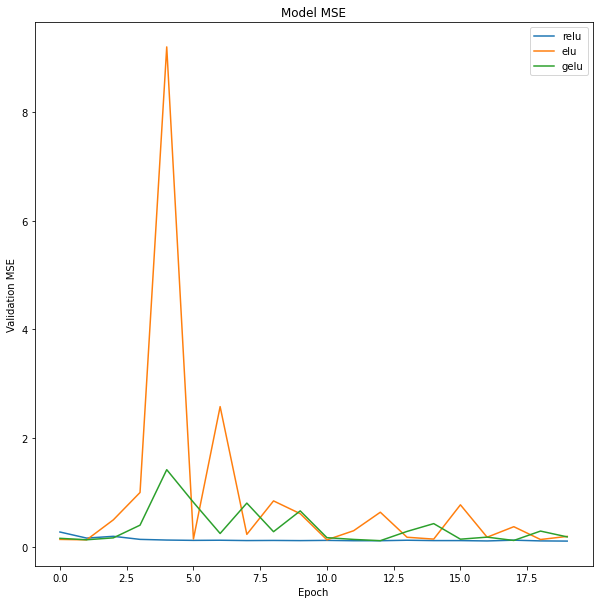

In [41]:
plot_act_func_results(result, act_func);

Relu è nettamente migliore

### Regolarizzazione
Aggiungiamo un rumore gaussiano iniziale con media zero e deviazione standard di 0,001 ai dati. L'aggiunta di rumore con varianza infinitesimale all'inizio del modello è equivalente a imporre una penalità sulla norma dei pesi.

In [42]:
#model 4 
model4 = Sequential() 
model4.add(Input(shape=train.shape[1]))
model4.add(GaussianNoise(0.001))
model4.add(Dense(1024, activation='relu'))
model4.add(Dense(512, activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1))

In [43]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 45)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              47104     
_________________________________________________________________
dense_36 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                

In [44]:
model4.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history4=model4.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.5779 - mse: 0.5779 - mae: 0.4205 - val_loss: 0.1547 - val_mse: 0.1547 - val_mae: 0.2945
Epoch 2/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.1408 - mse: 0.1408 - mae: 0.2796 - val_loss: 0.1306 - val_mse: 0.1306 - val_mae: 0.2669
Epoch 3/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.1369 - mse: 0.1369 - mae: 0.2673 - val_loss: 0.1240 - val_mse: 0.1240 - val_mae: 0.2584
Epoch 4/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.1224 - mse: 0.1224 - mae: 0.2573 - val_loss: 0.1201 - val_mse: 0.1201 - val_mae: 0.2561
Epoch 5/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.1170 - mse: 0.1170 - mae: 0.2506 - val_loss: 0.1196 - val_mse: 0.1196 - val_mae: 0.2559
Epoch 6/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.1142 - mse: 0.1142 - mae: 0.2468 - val_loss: 0.1192 - val_mse: 0.1192 - val_mae: 0.250

Si hanno leggeri miglioramenti in termini di mse sul validation.  
Aggiungiamo Layer di dropout dopo ciascun layer dense

In [45]:
#model 5
model5 = Sequential() 
model5.add(Input(shape=train.shape[1]))
model5.add(Dense(1024, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(1))

In [46]:
model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1024)              47104     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)              

In [47]:
model5.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history5=model5.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 15s 4ms/step - loss: 0.8727 - mse: 0.8727 - mae: 0.6215 - val_loss: 0.1371 - val_mse: 0.1371 - val_mae: 0.2745
Epoch 2/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.2381 - mse: 0.2381 - mae: 0.3801 - val_loss: 0.1277 - val_mse: 0.1277 - val_mae: 0.2634
Epoch 3/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.1884 - mse: 0.1884 - mae: 0.3346 - val_loss: 0.1223 - val_mse: 0.1223 - val_mae: 0.2566
Epoch 4/20
3951/3951 [==============================] - 14s 3ms/step - loss: 0.1582 - mse: 0.1582 - mae: 0.3031 - val_loss: 0.1155 - val_mse: 0.1155 - val_mae: 0.2479
Epoch 5/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.1385 - mse: 0.1385 - mae: 0.2797 - val_loss: 0.1151 - val_mse: 0.1151 - val_mae: 0.2478
Epoch 6/20
3951/3951 [==============================] - 13s 3ms/step - loss: 0.1260 - mse: 0.1260 - mae: 0.2643 - val_loss: 0.1142 - val_mse: 0.1142 - val_mae: 0.246

Non si hanno miglioramenti.  
Proviamo invece ad aggiungere un layer di normalizzazione batch dopo ciascun layer dense. Tale normalizzazione standardizza la distribuzione degli input di ciascun layer per combattere lo spostamento della covarianza interna. I parametri utilizzati in questo livello sono i parametri predefiniti di keras.

In [48]:
#model 6
model6 = Sequential() 
model6.add(Input(shape=train.shape[1]))
model6.add(Dense(1024, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(512, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(256, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(64, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(1))

In [49]:
model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1024)              47104     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_48 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_49 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_50 (Dense)             (None, 128)              

In [50]:
model6.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history6=model6.fit(X_trainst, y_train, batch_size=256, epochs=epochs, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 31s 8ms/step - loss: 5.3347 - mse: 5.3347 - mae: 1.2524 - val_loss: 0.1458 - val_mse: 0.1458 - val_mae: 0.2809
Epoch 2/20
3951/3951 [==============================] - 29s 7ms/step - loss: 0.1238 - mse: 0.1238 - mae: 0.2586 - val_loss: 0.1219 - val_mse: 0.1219 - val_mae: 0.2574
Epoch 3/20
3951/3951 [==============================] - 29s 7ms/step - loss: 0.1164 - mse: 0.1164 - mae: 0.2495 - val_loss: 0.1198 - val_mse: 0.1198 - val_mae: 0.2563
Epoch 4/20
3951/3951 [==============================] - 29s 7ms/step - loss: 0.1125 - mse: 0.1125 - mae: 0.2447 - val_loss: 0.1175 - val_mse: 0.1175 - val_mae: 0.2524
Epoch 5/20
3951/3951 [==============================] - 29s 7ms/step - loss: 0.1098 - mse: 0.1098 - mae: 0.2411 - val_loss: 0.1120 - val_mse: 0.1120 - val_mae: 0.2429
Epoch 6/20
3951/3951 [==============================] - 28s 7ms/step - loss: 0.1080 - mse: 0.1080 - mae: 0.2387 - val_loss: 0.1076 - val_mse: 0.1076 - val_mae: 0.237

Proviamo ora un modello con una regolarizzazione L2 del Kernel e del Bias. 

In [51]:
#model 7
initializer = GlorotUniform(seed=1234) 
model7 = Sequential() 
model7.add(Input(shape=train.shape[1]))
model7.add(Dense(1024, activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model7.add(Dense(512, activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model7.add(Dense(256, activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model7.add(Dense(128, activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model7.add(Dense(64, activation='relu', kernel_initializer=initializer, 
                 kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model7.add(Dense(1))

In [52]:
model7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1024)              47104     
_________________________________________________________________
dense_54 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_55 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_56 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_57 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 65        
Total params: 744,449
Trainable params: 744,449
Non-trainable params: 0
________________________________________________

In [53]:
model7.compile(optimizer='adam', loss='MeanSquaredError', metrics = ['mse', 'mae'])
history7=model7.fit(X_trainst, y_train, batch_size=256, epochs=epochs, shuffle=True, verbose=1, validation_data=(X_validationst, y_validation))

Epoch 1/20
3951/3951 [==============================] - 17s 4ms/step - loss: 1.2152 - mse: 0.6441 - mae: 0.4200 - val_loss: 0.2005 - val_mse: 0.1457 - val_mae: 0.2834
Epoch 2/20
3951/3951 [==============================] - 16s 4ms/step - loss: 0.1851 - mse: 0.1424 - mae: 0.2810 - val_loss: 0.1617 - val_mse: 0.1357 - val_mae: 0.2737
Epoch 3/20
3951/3951 [==============================] - 16s 4ms/step - loss: 0.1547 - mse: 0.1304 - mae: 0.2671 - val_loss: 0.1520 - val_mse: 0.1304 - val_mae: 0.2688
Epoch 4/20
3951/3951 [==============================] - 16s 4ms/step - loss: 0.1473 - mse: 0.1261 - mae: 0.2622 - val_loss: 0.1473 - val_mse: 0.1264 - val_mae: 0.2610
Epoch 5/20
3951/3951 [==============================] - 16s 4ms/step - loss: 0.1456 - mse: 0.1254 - mae: 0.2606 - val_loss: 0.1478 - val_mse: 0.1283 - val_mae: 0.2663
Epoch 6/20
3951/3951 [==============================] - 16s 4ms/step - loss: 0.1437 - mse: 0.1242 - mae: 0.2592 - val_loss: 0.1430 - val_mse: 0.1238 - val_mae: 0.258

kernel_initializer, bias_initializer, kernel_regularizer, bias_regularizer: abbiamo applicato la forma di regolarizzazione più semplice; la penalizzazione della norma dei parametri. Abbiamo inizializzato i pesi attraverso l'inizializzazione 'Glorot uniform', applicato una norm penalties L2 ai pesi e al bias ma non si sono ottenuti miglioramenti.

- per motivi di tempo di computazione abbiamo utilizzato solo 20 epoche. Non ci è parso perciò necessario utilizzare dei metodi di early stopping.

- batch size=256: abbiamo scelto come dimensione del batch  256, per sfruttare le capacità di elaborazione parallela nelle GPU. Avremmo potuto utilizzarne una di più piccola dimensione ma ciò si sarebbe tradotto in più iterazioni per epoca.

- abbiamo utilizzato adam come ottimizzatore, un algoritmo con un learning rate adattivo

#RISULTATI

In [54]:
nn = {'Model': ['Model1', 'Model2', 'Model3','Model4', 'Model5', 'Model6','Model7'],
      'MSE':[history1.history['mse'][-1], history2.history['mse'][-1], history3.history['mse'][-1], history4.history['mse'][-1],
            history5.history['mse'][-1], history6.history['mse'][-1], history7.history['mse'][-1]]}

In [13]:
nn={'MSE': [0.10328950732946396,
  0.10088684409856796,
  0.10065606981515884,
  0.0999450832605362,
  0.10898647457361221,
  0.09744395315647125,
  0.12005381286144257],
 'Model': ['Model1',
  'Model2',
  'Model3',
  'Model2 + rumore gaussiano',
  'Model2 + Dropout',
  'Model2 + normalizzazione batch ',
  'Model2 + regolarizzazione L2 ']}

a={'MSE': [0.10328950732946396,
  0.10088684409856796,
  0.10065606981515884,
  0.0999450832605362,
  0.10898647457361221,
  0.09744395315647125,
  0.12005381286144257],
 'Model': ['Model1',
  'Model2',
  'Model3',
  'Model4',
  'Model5',
  'Model6',
  'Model7']}

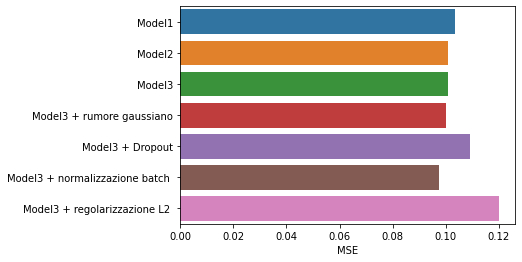

In [12]:
sns.barplot(nn['MSE'], nn['Model'], orient='h')
plt.xlabel('MSE');

Il modello neural network migliore è il modello 6.

In [56]:
nn_pred=model6.predict(X_validationst)

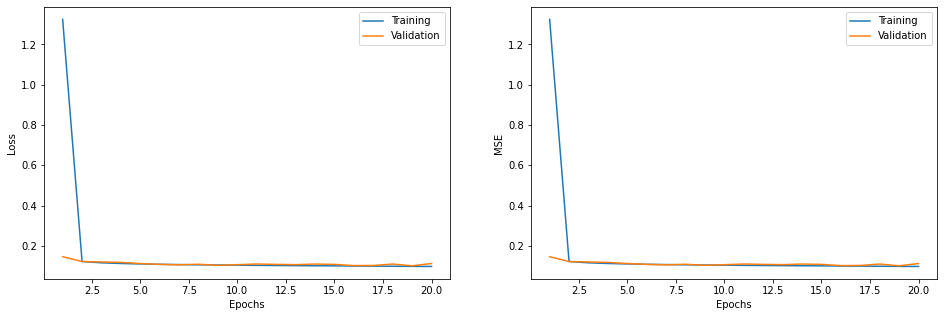

In [57]:
x_plot = list(range(1, epochs+1))
plot_history(history6)

In [59]:
lr_mae, lr_mse, lr_rmse, lr_r2 = performance(lr_pred, y_validation.values)
ab_mae, ab_mse, ab_rmse, ab_r2 = performance(ab_pred, y_validation.values)
lgbm_mae, lgbm_mse, lgbm_rmse, lgbm_r2 = performance(lgbm_pred, y_validation.values)
xgb_mae, xgb_mse, xgb_rmse, xgb_r2 = performance(xgb_pred, y_validation.values)
dt_mae, dt_mse, dt_rmse, dt_r2 = performance(dt_pred, y_validation.values)
cb_mae, cb_mse, cb_rmse, cb_r2 = performance(cb_pred, y_validation.values)
nn_mae, nn_mse, nn_rmse, nn_r2 = performance(nn_pred, y_validation.values)

In [80]:
#Creating dictionary for all the metrics and models
df = {'Metrics': ['MAE', 'MSE', 'RMSE','R2'],
      'Linear Regression':[lr_mae, lr_mse, lr_rmse, lr_r2],
      'AdaBoost':[ab_mae, ab_mse, ab_rmse, ab_r2],
      'LGBM':[lgbm_mae, lgbm_mse, lgbm_rmse, lgbm_r2],
      'XGBoost':[xgb_mae, xgb_mse, xgb_rmse, xgb_r2],
      'Decision Tree':[dt_mae, dt_mse, dt_rmse, dt_r2],
      'CatBoost':[cb_mae, cb_mse, cb_rmse, cb_r2],
      'Neural Network':[nn_mae, nn_mse, nn_rmse, nn_r2]}

In [81]:
df = pd.DataFrame(df)
df.set_index('Metrics', inplace=True)

Linear Regression	0.362885	0.223714	0.472984	0.287397
AdaBoost	0.349862	0.204691	0.452428	0.173281
LGBM	0.267420	0.130469	0.361204	0.664250
XGBoost	0.295269	0.153196	0.391403	0.572650
Decision Tree	0.352333	0.232739	0.482431	0.576277
CatBoost	0.352333	0.232739	0.482431	0.576277
Neural Network	0.241569	0.112013	0.334683	0.731252

In [82]:
df=df.transpose()
df

Metrics,MAE,MSE,RMSE,R2
Linear Regression,0.362885,0.223714,0.472984,0.287397
AdaBoost,0.349862,0.204691,0.452428,0.173281
LGBM,0.267420,0.130469,0.361204,0.664250
XGBoost,0.295269,0.153196,0.391403,0.572650
Decision Tree,0.352333,0.232739,0.482431,0.576277
CatBoost,0.352333,0.232739,0.482431,0.576277
Neural Network,0.241569,0.112013,0.334683,0.731252


In [83]:
df.reset_index(inplace=True)
df.rename(columns={"index": "Model"}, inplace=True)

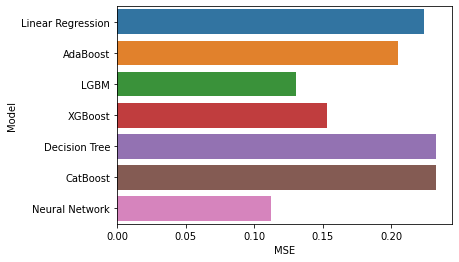

In [84]:
sns.barplot( df['MSE'],df['Model'], orient='h');